In [13]:
import sys
print(sys.executable)


/home/zim/codes-2025/machine-learnings/sentiment-analysis-final-cnn/venv/bin/python


In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [15]:
#dataset
df = pd.read_csv("IMDB_Dataset.csv")

# convert positive/negative to 1/0
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

texts = df["review"].astype(str).values
labels = df["sentiment"].values

In [16]:
#splitting dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [17]:
#tokenize + pad
vocab_size = 20000
maxlen = 200

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

In [18]:
#learning rate decay

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [19]:
#build model
def build_cnn(vocab_size, embed_dim=128, maxlen=200):
    model = models.Sequential([
        layers.Embedding(vocab_size, embed_dim, input_length=maxlen),

        layers.Conv1D(128, kernel_size=3, activation="relu"),
        layers.GlobalMaxPooling1D(),

        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),

        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn(vocab_size)
model.summary()

/home/zim/codes-2025/machine-learnings/sentiment-analysis-final-cnn/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
#training
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7896 - loss: 0.4361 - val_accuracy: 0.8871 - val_loss: 0.2722 - learning_rate: 0.0010
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7896 - loss: 0.4361 - val_accuracy: 0.8871 - val_loss: 0.2722 - learning_rate: 0.0010
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9228 - loss: 0.2006 - val_accuracy: 0.8956 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9228 - loss: 0.2006 - val_accuracy: 0.8956 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9789 - loss: 0.0727 - val_accuracy: 0.8999 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9789 - loss: 0.0727 - val_accuracy: 0.8999 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9965 - loss: 0.0180 

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8944 - loss: 0.2622
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8944 - loss: 0.2622
Test Accuracy: 0.8944000005722046
Test Loss: 0.26222625374794006
Test Accuracy: 0.8944000005722046
Test Loss: 0.26222625374794006
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3722
           1       0.87      0.93      0.90      3778

    accuracy                           0.89      7500
   macro avg       0.90      0.89      0.89      7500
weighted avg       0.90      0.89      0.89      7500


Confusion Matrix:
[[3204  518]
 [ 274 3504]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3722
           1       0.87      0.93      0.90      3778

    accuracy                           0.89      7500

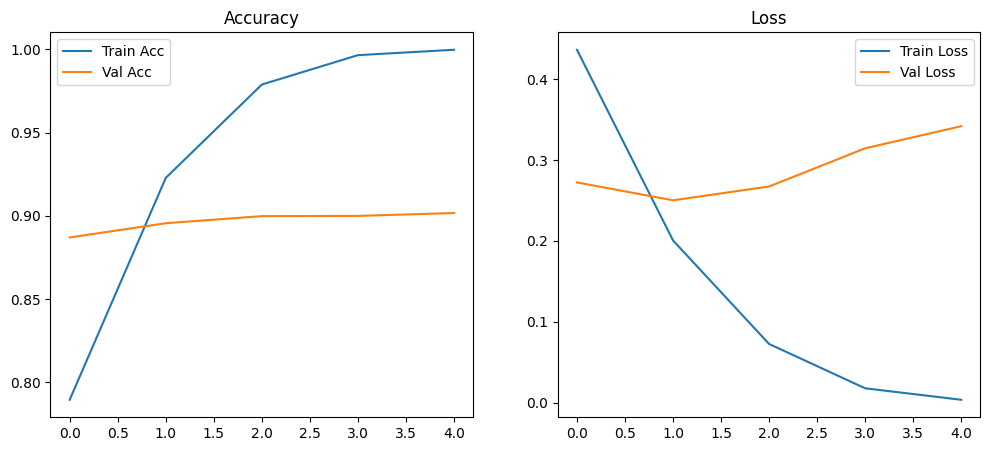

In [21]:
#eval
loss, accuracy = model.evaluate(X_test_seq, y_test)
print("Test Accuracy:", accuracy)
print("Test Loss:", loss)

#classification metrics
y_pred = (model.predict(X_test_seq) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#plot accuracy + loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()

In [22]:
#save model and tokenizer for deployment
import pickle

model.save('sentiment_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Model saved as sentiment_model.h5")
print("Tokenizer saved as tokenizer.pkl")

Model saved as sentiment_model.h5
Tokenizer saved as tokenizer.pkl
